# Machine Learning

## Set up

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load data
df = pd.read_pickle("sample")
# show numerical values
df.describe()

,backers_count,goal,pledged,life,duration,prep
count,321706.000000,3.217060e+05,3.217060e+05,321706,321706,321706
mean,133.651999,4.480449e+04,1.204134e+04,33 days 23:14:38.298614,31 days 14:24:38.233132,43 days 03:14:40.443205
std,1016.287065,1.132613e+06,1.218443e+05,12 days 18:40:51.197709,14 days 11:46:25.057715,111 days 18:40:51.602311
min,0.000000,1.000000e-02,0.000000e+00,1 days 00:00:00,-1 days +23:17:57,0 days 00:01:41
25%,2.000000,2.000000e+03,6.000000e+01,30 days 00:00:00,28 days 13:19:39,2 days 18:20:33
50%,21.000000,5.000000e+03,1.176000e+03,30 days 00:00:00,30 days 00:00:01,10 days 03:27:52
75%,77.000000,1.500000e+04,5.715000e+03,36 days 03:17:57,35 days 00:00:00,34 days 03:13:45
max,219382.000000,1.000000e+08,2.902191e+07,91 days 23:00:00,354 days 19:06:23,2313 days 16:40:37


In [6]:
# convert duration data to seconds
df['life_days'] = df['life'].dt.days
df['prep_days'] = df['prep'].dt.days
df['launch_month'] = df['launched_at'].dt.month.astype('category')
# df['top100'] = df['top100'].fillna(99).astype(int)

In [7]:
# keep only successful / fail projects
# keep only US projects
data = df[(df.location_country =="US") & ((df.state == "successful")|(df.state == "failed"))].reset_index(drop = True)

# keep only numerical/categorical variables
DropCol = ['location_country','location_state','location_localized_name','location_name','creator_name',
      'category_name','launched_at','deadline','state_changed_at','life','duration','prep','pledged','backers_count']

data = data.drop(DropCol,axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 241717 entries, 0 to 241716
Data columns (total 9 columns):
goal              241717 non-null float64
gender            241717 non-null object
category_broad    241717 non-null category
state             241717 non-null category
slug              241717 non-null object
blurb             241714 non-null object
life_days         241717 non-null int64
prep_days         241717 non-null int64
launch_month      241717 non-null category
dtypes: category(3), float64(1), int64(2), object(3)
memory usage: 11.8+ MB


## Text Analysis 
### Structure analysis of headline
Reference: http://nbviewer.jupyter.org/github/AYLIEN/headline_analysis/blob/06f1223012d285412a650c201a19a1c95859dca1/main-chunks.ipynb#A-primer-on-parse-trees

### Sentiment analysis

In [8]:
print(data.slug.sample(5))
print(data.blurb[5])

215491                   brandon-schotts-crayons-and-angels
5904                                  the-skin-i-wish-i-had
13347             creator-kits-the-next-step-in-3d-printing
53200     dance-aegis-warning-this-piece-contains-dark-t...
240513                          puzzle-stones-needs-porting
Name: slug, dtype: object
Last year, I completed my first novel, The Circumstance of Marriage. Now I need your help to get an editor to get it published!


In [9]:
from textblob import TextBlob

def sentiment_calc(text):
    try:
        return TextBlob(text).sentiment
    except:
        return None

# test
sentiment_calc(data['blurb'][5])

Sentiment(polarity=0.15625, subjectivity=0.19999999999999998)

In [10]:
data['slug'] = data['slug'].str.replace('-',' ')
data.slug.sample(5)

36678     mother urbans food truck bluesky organic farm
110263           happy hands childrens handwashing song
141741                               feed your stepdads
66856              diep9 genever reviving a lost spirit
140657          greg louganis documentary back on board
Name: slug, dtype: object

In [11]:
data['slug_senti'] =  data['slug'].apply(sentiment_calc)
data[['slug_plor','slug_subj']] = data['slug_senti'].apply(pd.Series)

data['blurb_senti'] =  data['blurb'].apply(sentiment_calc)
data[['blurb_plor','blurb_subj']] = data['blurb_senti'].apply(pd.Series)

In [12]:
data[['blurb_plor','blurb_subj']] = data[['blurb_plor','blurb_subj']].fillna(value=0)
data.sample(5)

,goal,gender,category_broad,state,slug,blurb,life_days,prep_days,launch_month,slug_senti,slug_plor,slug_subj,blurb_senti,blurb_plor,blurb_subj
230352,8000.0,male,music,failed,the dirty concubines,An album by zack korth.,29,0,2,"(-0.6, 0.8)",-0.6,0.8,"(0.0, 0.0)",0.000000,0.000000
178104,1300.0,female,crafts,failed,crown city candles october 2014 collection,Certain smells trigger specific memories. Remi...,33,0,4,"(0.0, 0.0)",0.0,0.0,"(0.2380952380952381, 0.5654761904761905)",0.238095,0.565476
27527,700.0,unknown,technology,successful,the fancy snarks official website,A new home for gamers like you. A community site.,60,32,12,"(0.0, 0.0)",0.0,0.0,"(0.13636363636363635, 0.45454545454545453)",0.136364,0.454545
28219,2999.0,unknown,theater,successful,or what she will,or what she will was invited to the NYC Fringe...,30,11,6,"(0.0, 0.0)",0.0,0.0,"(0.0, 0.0)",0.000000,0.000000
77704,40000.0,unknown,music,failed,the rise to success conquering the jungle,One artist journey to create music filled with...,31,89,5,"(0.3, 0.0)",0.3,0.0,"(0.275, 0.48125)",0.275000,0.481250


## Remove Outliers

In [21]:
CatCol = ['gender','launch_month','category_broad']
NumCol = ['goal','life_days','prep_days','slug_plor','slug_subj','blurb_plor','blurb_subj']

data.describe()

,goal,life_days,prep_days,slug_plor,slug_subj,blurb_plor,blurb_subj
count,2.417170e+05,241717.000000,241717.000000,241717.000000,241717.000000,241717.000000,241717.000000
mean,3.750493e+04,33.604207,43.820964,0.044745,0.169475,0.144878,0.397224
std,1.033886e+06,12.837902,114.860399,0.192110,0.275100,0.255678,0.285698
min,1.000000e-02,1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000
25%,2.000000e+03,30.000000,2.000000,0.000000,0.000000,0.000000,0.158333
50%,5.000000e+03,30.000000,10.000000,0.000000,0.000000,0.100000,0.400000
75%,1.300000e+04,35.000000,34.000000,0.000000,0.333333,0.290625,0.591667
max,1.000000e+08,91.000000,2313.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
import collections
c = collections.Counter()

for feature in NumCol:
    
    Q1 = np.percentile(data[feature], 25)
    Q3 = np.percentile(data[feature], 75)
    
    step = 1.5 * (Q3 - Q1)
    
    outlier = data[(~(data[feature] >= Q1 - step) & (data[feature] <= Q3 + step))]
    
    c.update(outlier.index)

In [15]:
# remove projects that have at least 2 outlier features
outliers = []

for ind,num in c.items(): 
    if num >= 2:
        outliers.append(ind)
        
len(outliers)/len(data)

0.014293574717541589

In [16]:
good_data = data.drop(data.index[outliers]).reset_index(drop = True)
good_data.describe()

,goal,life_days,prep_days,slug_plor,slug_subj,blurb_plor,blurb_subj
count,2.382620e+05,238262.000000,238262.000000,238262.000000,238262.000000,238262.000000,238262.000000
mean,3.791276e+04,33.803049,44.008684,0.049413,0.165154,0.149187,0.395252
std,1.041339e+06,12.766680,115.194444,0.187346,0.272451,0.250891,0.285127
min,1.000000e-02,1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000
25%,2.000000e+03,30.000000,2.000000,0.000000,0.000000,0.000000,0.150000
50%,5.000000e+03,30.000000,10.000000,0.000000,0.000000,0.100000,0.400000
75%,1.350000e+04,36.000000,34.000000,0.000000,0.333333,0.293651,0.587500
max,1.000000e+08,91.000000,2313.000000,1.000000,1.000000,1.000000,1.000000


## Scaling and normalization

In [17]:
# split into features and target
target = good_data['state'].apply(lambda x: 1 if x == "successful" else 0)
feature = good_data.drop(['state','slug','blurb','slug_senti','blurb_senti'], axis = 1)

print(feature.head())
print(target.head())

     goal   gender category_broad  life_days  prep_days launch_month  \
0  2000.0     male     publishing         30         68           12   
1  2100.0  unknown     publishing         30         43            1   
2   500.0   female     publishing         30          7            1   
3   500.0   female     publishing         30          7            1   
4   500.0   female     publishing         30          7            1   

   slug_plor  slug_subj  blurb_plor  blurb_subj  
0  -0.166667   0.333333   -0.003333    0.436667  
1  -0.291667   0.541667    0.000000    0.000000  
2   0.000000   0.000000    0.156250    0.200000  
3   0.000000   0.000000    0.156250    0.200000  
4   0.000000   0.000000    0.156250    0.200000  
0    1
1    1
2    1
3    1
4    1
Name: state, dtype: int64


In [18]:
# log data
feature[NumCol] = np.log(feature[NumCol]+1.00001)

In [19]:
# MinMax Scale
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
feature[NumCol] = scaler.fit_transform(feature[NumCol])


In [20]:
# pd.plotting.scatter_matrix(feature, alpha = 0.3, figsize = (14,8), diagonal = 'kde');
# feature.corr()

## One-hot-encoding categorical variables

In [22]:
feature_final = pd.get_dummies(feature, columns = CatCol,drop_first=True)
# feature_final = feature.drop(CatCol, axis = 1)
feature_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238262 entries, 0 to 238261
Data columns (total 37 columns):
goal                           238262 non-null float64
life_days                      238262 non-null float64
prep_days                      238262 non-null float64
slug_plor                      238262 non-null float64
slug_subj                      238262 non-null float64
blurb_plor                     238262 non-null float64
blurb_subj                     238262 non-null float64
gender_female                  238262 non-null uint8
gender_male                    238262 non-null uint8
gender_mostly_female           238262 non-null uint8
gender_mostly_male             238262 non-null uint8
gender_unknown                 238262 non-null uint8
launch_month_2                 238262 non-null uint8
launch_month_3                 238262 non-null uint8
launch_month_4                 238262 non-null uint8
launch_month_5                 238262 non-null uint8
launch_month_6             

In [23]:
feature_final.to_pickle('feature_final')
target.to_pickle('target')

In [3]:
feature_final = pd.read_pickle("feature_final")
target = pd.read_pickle("target")

## Pipeline

In [4]:
# split train-test
from sklearn.model_selection import train_test_split

# feature_final = feature_final.drop(['category_broad'],axis = 1)


X_train, X_test, y_train, y_test = train_test_split(feature_final,
                                                   target, 
                                                   test_size = 0.2,
                                                   random_state = 23)
print(X_train.shape)
print(X_test.shape)

(190609, 37)
(47653, 37)


In [17]:
from sklearn.metrics import fbeta_score, accuracy_score
from time import time

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test):
    results = {}
    
    # training
    start = time()
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time()
    
    results['train_time'] = end - start
    
    # prediction
    
    start = time()
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time()
    
    results['pred_time'] = end - start
    
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['f_train'] = fbeta_score(y_train[:300], predictions_train,0.5)
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
    
    print("{} trained on {} samples. ".format(learner.__class__.__name__, sample_size))

    return results

In [18]:
# naive score
precision = accuracy = np.sum(target)/len(target)

recall = 1
fscore = (1+0.25)*precision*recall/(0.25*precision+recall)

print("Naive Predictor: accuracy: {:.4f}, F:{:.4f}".format(accuracy, fscore))

Naive Predictor: accuracy: 0.5415, F:0.5962


### Training!

In [19]:
# from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


# clf_S = SVC(random_state = 2)
clf_Logit = LogisticRegression(random_state = 25)
clf_RF = RandomForestClassifier(random_state = 23)
clf_LDA = LinearDiscriminantAnalysis(n_components = 5)

samples_100 = len(y_train)
samples_10 = int(0.1*samples_100)
samples_1 = int(0.01*samples_100)

results = {}
for clf in [clf_Logit, clf_RF, clf_LDA]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1,samples_10, samples_100]):
        results[clf_name][i] = train_predict(clf, samples, X_train, y_train, X_test, y_test)


LogisticRegression trained on 1906 samples. 
LogisticRegression trained on 19060 samples. 
LogisticRegression trained on 190609 samples. 
RandomForestClassifier trained on 1906 samples. 
RandomForestClassifier trained on 19060 samples. 
RandomForestClassifier trained on 190609 samples. 
LinearDiscriminantAnalysis trained on 1906 samples. 
LinearDiscriminantAnalysis trained on 19060 samples. 
LinearDiscriminantAnalysis trained on 190609 samples. 


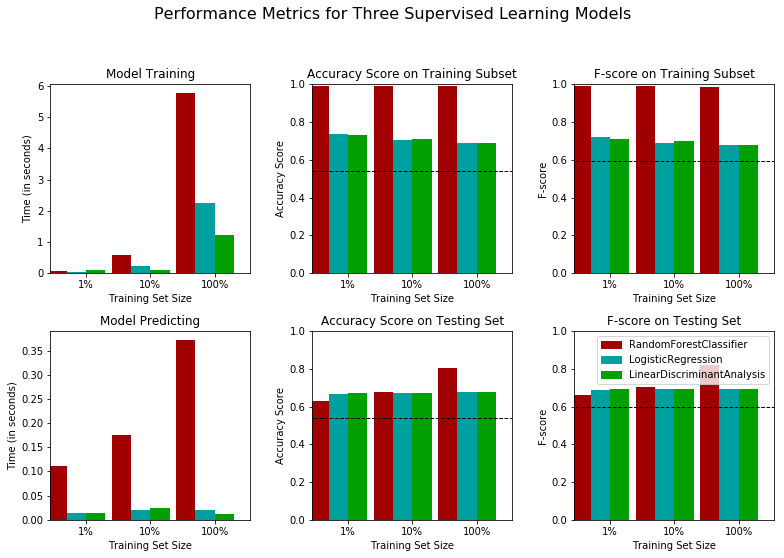

In [31]:
evaluate(results, accuracy, fscore)
# print("Logit: accuracy score is {:.4f}".format(results['LogisticRegression']['acc_test']))
# print("Random Forest : accuracy score is {:.4f}".format(results['RandomForestClassifier']['acc_test']))
# print("LDA : accuracy score is {:.4f}".format(results['LinearDiscriminantAnalysis']['acc_test']))
# results

In [30]:
import matplotlib.patches as mpatches

def evaluate(results, accuracy, f1):
    """
    Visualization code to display results of various learners.
    
    inputs:
      - learners: a list of supervised learners
      - stats: a list of dictionaries of the statistic results from 'train_predict()'
      - accuracy: The score for the naive predictor
      - f1: The score for the naive predictor
    """
  
    # Create figure
    fig, ax = plt.subplots(2, 3,figsize = (11,7))

    # Constants
    bar_width = 0.3
    colors = ['#A00000','#00A0A0','#00A000']
    
    # Super loop to plot four panels of data
    for k, learner in enumerate(results.keys()):
        for j, metric in enumerate(['train_time', 'acc_train', 'f_train', 'pred_time', 'acc_test', 'f_test']):
            for i in np.arange(3):
                
                # Creative plot code
                ax[j//3, j%3].bar(i+k*bar_width, results[learner][i][metric], width = bar_width, color = colors[k])
                ax[j//3, j%3].set_xticks([0.45, 1.45, 2.45])
                ax[j//3, j%3].set_xticklabels(["1%", "10%", "100%"])
                ax[j//3, j%3].set_xlabel("Training Set Size")
                ax[j//3, j%3].set_xlim((-0.1, 3.0))
    
    # Add unique y-labels
    ax[0, 0].set_ylabel("Time (in seconds)")
    ax[0, 1].set_ylabel("Accuracy Score")
    ax[0, 2].set_ylabel("F-score")
    ax[1, 0].set_ylabel("Time (in seconds)")
    ax[1, 1].set_ylabel("Accuracy Score")
    ax[1, 2].set_ylabel("F-score")
    
    # Add titles
    ax[0, 0].set_title("Model Training")
    ax[0, 1].set_title("Accuracy Score on Training Subset")
    ax[0, 2].set_title("F-score on Training Subset")
    ax[1, 0].set_title("Model Predicting")
    ax[1, 1].set_title("Accuracy Score on Testing Set")
    ax[1, 2].set_title("F-score on Testing Set")
    
    # Add horizontal lines for naive predictors
    ax[0, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 1].axhline(y = accuracy, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[0, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    ax[1, 2].axhline(y = f1, xmin = -0.1, xmax = 3.0, linewidth = 1, color = 'k', linestyle = 'dashed')
    
    # Set y-limits for score panels
    ax[0, 1].set_ylim((0, 1))
    ax[0, 2].set_ylim((0, 1))
    ax[1, 1].set_ylim((0, 1))
    ax[1, 2].set_ylim((0, 1))
    
    patches = []
    for i, learner in enumerate(results.keys()):
        patches.append(mpatches.Patch(color = colors[i], label = learner))
    plt.legend(handles = patches)
 
    
    # Aesthetics
    plt.suptitle("Performance Metrics for Three Supervised Learning Models", fontsize = 16, y = 1.10)
    plt.tight_layout()
    plt.savefig("plots/result.png")

### Tuning

In [7]:
# Random Forest Tuning
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = RandomForestClassifier(random_state = 23)

parameters = {"n_estimators": [10, 18, 22],
              "min_samples_split": [2, 5, 10],
              "min_samples_leaf": [1, 5, 10]}

scorer = make_scorer(fbeta_score, beta = 0.5)
grid_obj = GridSearchCV(clf, parameters, scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print("untuned accuracy:{:.4f}".format(accuracy_score(y_test, predictions)))
print("optimized accuracy:{:.4f}".format(accuracy_score(y_test, best_predictions)))

print("untuned accuracy:{:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("optimized accuracy:{:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


untuned accuracy:0.8018
optimized accuracy:0.8098
untuned accuracy:0.8218
optimized accuracy:0.8236


### Parameters

In [35]:
def feature_plot(importances, X_train, y_train):
    
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:5]]
    values = importances[indices][:5]

    # Creat the plot
    fig = plt.figure(figsize = (9,5))
    plt.title("Normalized Weights for First Five Most Predictive Features", fontsize = 16)
    plt.bar(np.arange(5), values, width = 0.6, align="center", color = '#00A000', \
          label = "Feature Weight")
    plt.bar(np.arange(5) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', \
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(5), columns)
    plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper center')
    plt.tight_layout()
    plt.savefig('plots/rf_imp.png')  

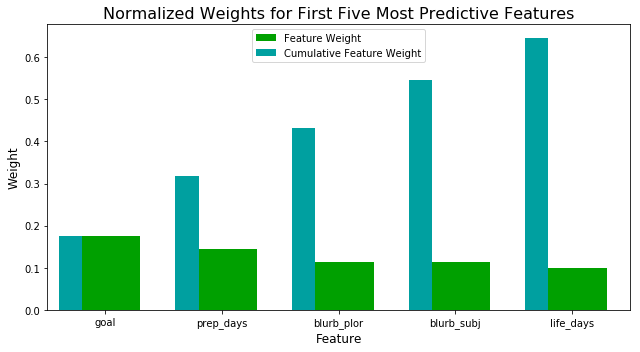

In [36]:
importances = best_clf.feature_importances_
feature_plot(importances, X_train, y_train)
# importances

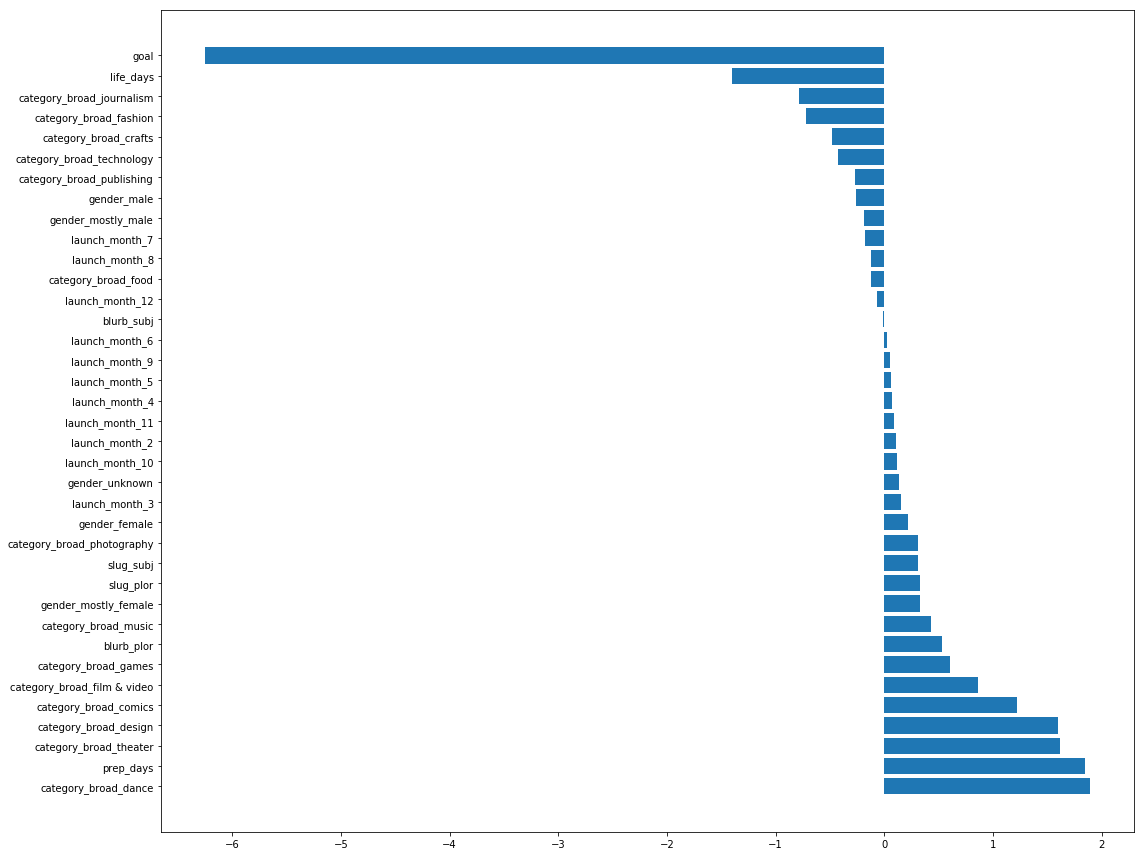

In [39]:
coeffs = clf_Logit.coef_
indices = np.argsort(coeffs)[0][::-1]
columns = X_train.columns.values[indices]
values = coeffs[0][indices]

fig = plt.figure(figsize = (16,12))
plt.barh(np.arange(37), values, align="center")
plt.yticks(np.arange(37), columns)
plt.tight_layout()
plt.show()  

In [44]:
# run statistic model to get result summary
import statsmodels.discrete.discrete_model as sm
logit = sm.Logit(y_train, X_train)
print (logit.fit().summary())

Optimization terminated successfully.
         Current function value: 0.600170
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                  state   No. Observations:               190609
Model:                          Logit   Df Residuals:                   190572
Method:                           MLE   Df Model:                           36
Date:                Mon, 13 Aug 2018   Pseudo R-squ.:                  0.1297
Time:                        00:26:32   Log-Likelihood:            -1.1440e+05
converged:                       True   LL-Null:                   -1.3144e+05
                                        LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
goal                           -6.2287      0.069    -90.612      0.000   

## CNN

In [118]:
import keras

# Separate data and one-hot encode the output
# Note: We're also turning the data into numpy arrays, in order to train the model in Keras
features = np.array(X_train)
targets = np.array(pd.get_dummies(y_train))
features_test = np.array(X_test)
targets_test = np.array(pd.get_dummies(y_test))

print(features[:10])
print(targets[:10])

Using TensorFlow backend.


[[ 0.54950108  0.71587766  0.          0.93163285  0.51326042  0.93474698
   0.52788863  0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          1.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.71221575  0.71587766  0.30953556  0.96149454  0.41503689  0.95286281
   0.16992462  0.          0.          0.          1.          0.          1.
   0.          0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.        ]
 [ 0.46209125  0.76905557  0.          0.94321336  0.          0.96626827
   0.70781876  1.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.          0.
   0.        ]
 [ 0.40351551  0.71587766  0.33

In [119]:
# Imports

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.utils import np_utils

# Building the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(28,)))
model.add(Dropout(.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(.1))
model.add(Dense(2, activation='sigmoid'))

# Compiling the model
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               3712      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 12,098
Trainable params: 12,098
Non-trainable params: 0
_________________________________________________________________


In [127]:
# Training the model
model.fit(features, targets, epochs=200, batch_size=2000, verbose=0)

In [128]:
# Evaluating the model on the training and testing set
score = model.evaluate(features, targets)
print("\n Training Accuracy:", score[1])
score = model.evaluate(features_test, targets_test)
print("\n Testing Accuracy:", score[1])

126126/126126 [==============================] - 10s 78us/step

 Training Accuracy: 0.694004408292
31532/31532 [==============================] - 3s 81us/step

 Testing Accuracy: 0.690695166822


## SANDBOX

### LDA Regression

In [125]:
# LDA Regression
from sklearn.model_selection  import GridSearchCV
from sklearn.metrics import make_scorer

clf = LinearDiscriminantAnalysis()

parameters = {'n_components':[2,5,10,15,20,25],
             'solver':['svd','lsqr','eigen']}

scorer = make_scorer(fbeta_score, beta = 0.5)
grid_obj = GridSearchCV(clf, parameters, scorer)

grid_fit = grid_obj.fit(X_train, y_train)

best_clf = grid_fit.best_estimator_

predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

print("untuned accuracy:{:.4f}".format(accuracy_score(y_test, predictions)))
print("optimized accuracy:{:.4f}".format(accuracy_score(y_test, best_predictions)))

print("untuned accuracy:{:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("optimized accuracy:{:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))


untuned accuracy:0.6766
optimized accuracy:0.6766
untuned accuracy:0.6900
optimized accuracy:0.6900


In [126]:
best_clf.coef_

array([[-6.25971837, -1.45492172,  1.92071934,  0.76411841,  0.28376298,
         0.3314164 , -0.0161366 ,  0.10241837, -0.32302196,  0.22919516,
        -0.29781926,  0.0974614 ,  0.29793325,  0.02297696,  1.29525514,
        -0.42619425,  1.48884427,  1.55514827, -0.71588503,  0.84891553,
        -0.08413024,  0.72978401, -0.78569546,  0.56887739,  0.36317533,
        -0.16710109, -0.37789836,  1.39968973]])

## Feature Importance

### Sentence structure analysis

In [3]:
# SpaCy for structure analysis
import spacy 
from spacy import displacy
import difflib

EN = spacy.load("en")
nlp = spacy.load('en_core_web_sm')

In [35]:
# test tokens
data.slug.sample(5)

699                                        hotel-chicamauga
72401                          hearts-and-daggers-new-album
153857    help-kickstart-welcome-to-limericks-debut-ep-a...
149150    got-emissions-275-inch-x-9-inch-vinyl-bumper-s...
76986                                     the-warped-vinyls
Name: slug, dtype: object

In [39]:
slugs = [slug for slug in data['slug']]
slugs[1]

'chasing-gold-lined-storms'

In [90]:
def tokenize_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d slugs." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.pos_ for tok in doc]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

In [96]:
# tokenize all slugs.

slugs_tokenize = tokenize_text(slugs, True)

In [40]:
# slugs_tokenize.to_pickle("slugs_tokenize")
slugs_tokenize = pd.read_pickle("slugs_tokenize")
slugs_tokenize[1]


'VERB PUNCT NOUN PUNCT VERB PUNCT NOUN'

In [4]:
# difference in length and structure sequence
difflib.SequenceMatcher(None,slugs_tokenize[10],slugs_tokenize[2]).ratio()


0.6216216216216216

Select a random sample randomly to train the classifier， calculate Pair-wise similarity matrix for the headlines

In [23]:
# 1000 training set
np.random.seed(10)
sample_size = 1000
sample_index = np.random.randint(0, len(slugs_tokenize), sample_size)
m = np.zeros((sample_size,sample_size))

for i, slug_x in enumerate(slugs_tokenize[sample_index]):
    for j, slug_y in enumerate(slug_x):
        m[i][j] = difflib.SequenceMatcher(None,slug_x,slug_y).ratio()

In [24]:
m.shape

(1000, 1000)

use tSNE to reduce the dimensionality of similarity matrix from 1000 down to 2:

In [25]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)

In [26]:
tsne = tsne_model.fit_transform(m)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.028s...
[t-SNE] Computed neighbors for 1000 samples in 0.653s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 40.082664
[t-SNE] Error after 1000 iterations: 0.087015


In [27]:
from sklearn.cluster import MiniBatchKMeans

kmeans_model = MiniBatchKMeans(n_clusters=5, init='k-means++', n_init=1, 
                         init_size=1000, batch_size=1000, verbose=False, max_iter=1000)
kmeans = kmeans_model.fit(m)
kmeans_clusters = kmeans.predict(m)
kmeans_distances = kmeans.transform(m)

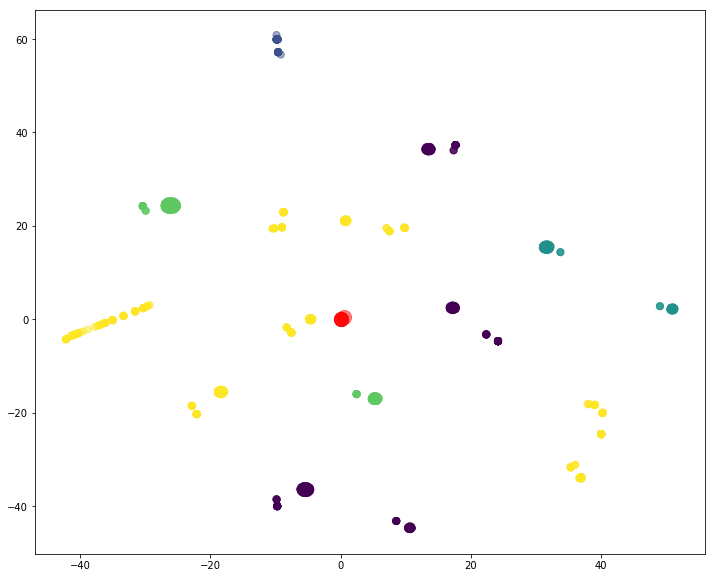

In [28]:
plt.figure(figsize=(12,10))

plt.scatter(tsne[:, 0], tsne[:, 1], c=kmeans_clusters, s=50, cmap='viridis' ,alpha =0.5)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200,  alpha=0.5)
